# Benign Overfitting in Finance

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## **Step 0:** load the data, train/test split, standardize, etc.

In [3]:
df = pd.read_parquet("C:\\Users\\monci\\OneDrive\\Desktop\\M2_COURSES\\ADVANCED ML\\Advanced-ML-benign-overfitting-finance\\data\\processed\\equities_panel.parquet")
print(df.shape)
df.head(3)

(69038, 15)


,Ticker,Date,Adj Close,Volume,ret,log_volume,mkt_ew_ret,mom_1m,mom_3m,mom_6m,mom_12m,vol_12m,ret_fwd,y,y_cs
0,A,2001-01-31,32.664322,3.761525e+06,-0.003653,15.140335,0.031220,-0.003653,0.057435,0.069642,0.018801,0.282544,-0.340055,0,0
1,A,2001-02-28,21.556658,4.274069e+06,-0.340055,15.268077,-0.038522,-0.340055,-0.098202,-0.069856,-0.056987,0.240233,-0.146389,0,0
2,A,2001-03-31,18.401001,4.019854e+06,-0.146389,15.206756,-0.040611,-0.146389,-0.163366,-0.061297,-0.069287,0.240760,0.269444,1,1


In [4]:
df['Date']=pd.to_datetime(df['Date'])
df = df.sort_values(["Date", "Ticker"]).reset_index(drop=True)
features = ["log_volume","mkt_ew_ret","mom_1m","mom_3m","mom_6m","mom_12m","vol_12m"]
X = df[features].values
y = df["ret_fwd"].values

split_date = "2015-01-01"

train_mask = df["Date"] < split_date
test_mask  = df["Date"] >= split_date

X_train_base = X[train_mask]
X_test_base  = X[test_mask]
y_train = y[train_mask]
y_test  = y[test_mask]

scaler = StandardScaler()
X_train_base = scaler.fit_transform(X_train_base)
X_test_base  = scaler.transform(X_test_base)

# Normalize target feature
y_mean = y_train.mean()
y_train = y_train - y_mean
y_test  = y_test - y_mean

## STEP 0.5 — Baseline linear regression (NO REGULARIZATION, showing that the problem is already hard)

In [5]:
def mse_loss(X, y, w):
    r = X @ w - y
    return np.mean(r ** 2)

def grad_mse(X, y, w):
    n = X.shape[0]
    return (2 / n) * X.T @ (X @ w - y)


In [6]:
def train_gd(X, y, lr=0.1, max_iter=5000, tol=1e-8):
    d = X.shape[1]
    w = np.zeros(d)

    for it in range(max_iter):
        grad = grad_mse(X, y, w)
        w -= lr * grad

        if mse_loss(X, y, w) < tol:
            break

    return w, it


In [7]:
w_base, iters_base = train_gd(X_train_base, y_train)

base_train = mse_loss(X_train_base, y_train, w_base)
base_test  = mse_loss(X_test_base, y_test, w_base)
base_norm = np.linalg.norm(w_base)

print("BASELINE")
print("Train MSE:", base_train)
print("Test MSE :", base_test)
print("||w||2   :", base_norm)


BASELINE
Train MSE: 0.010509287702696456
Test MSE : 0.007612134774534571
||w||2   : 0.013971230264574256


## Increase dimension

In [8]:
rng = np.random.default_rng(0)

# --- pick a manageable subset so d=1000 can overfit ---
n_sub = 600   # try 300–800; MUST be < 1000
idx = rng.choice(X_train_base.shape[0], size=n_sub, replace=False)

Xb_tr = X_train_base[idx].astype(np.float32)
yb_tr = y_train[idx].astype(np.float32)

# (optional) evaluate test on a subset too, to keep it light
t_sub = 2000
tidx = rng.choice(X_test_base.shape[0], size=t_sub, replace=False)
Xb_te = X_test_base[tidx].astype(np.float32)
yb_te = y_test[tidx].astype(np.float32)

d0 = Xb_tr.shape[1]          # 7
d = 1000
m = d - d0                   # 993


In [9]:
W = rng.normal(size=(d0, m)).astype(np.float32)
b = rng.normal(size=(m,)).astype(np.float32)

Z_tr = np.maximum(0, Xb_tr @ W + b)     # ReLU features
Z_te = np.maximum(0, Xb_te @ W + b)

X_tr = np.hstack([Xb_tr, Z_tr]).astype(np.float32)   # (n_sub, 1000)
X_te = np.hstack([Xb_te, Z_te]).astype(np.float32)   # (t_sub, 1000)

# --- minimum-norm interpolator via kernel trick ---
K = X_tr @ X_tr.T                       # (n_sub, n_sub)
lam = 1e-4                              # tiny jitter for numerical stability
alpha = np.linalg.solve(K + lam*np.eye(n_sub, dtype=np.float32), yb_tr)
w = X_tr.T @ alpha                      # (1000,)

train_mse = float(np.mean((X_tr @ w - yb_tr)**2))
test_mse  = float(np.mean((X_te @ w - yb_te)**2))
wnorm     = float(np.linalg.norm(w))

print("OVERFIT DEMO (d=1000, n_sub=", n_sub, ")")
print("Train MSE:", train_mse)
print("Test MSE :", test_mse)
print("||w||2   :", wnorm)

OVERFIT DEMO (d=1000, n_sub= 600 )
Train MSE: 2.716623725973477e-08
Test MSE : 0.0293305441737175
||w||2   : 1.0792979001998901


What “benign overfitting” actually means (strict definition)
Benign overfitting is not:
- “The model interpolates and test error is okay.”

It is:
- As model size increases past the interpolation threshold, training error stays ~0, and test error does not get worse and may even improve-

In [10]:
def fit_relu_random_features_kernel(X_train_base, y_train, X_test_base, y_test,n_sub=600, t_sub=2000, d=1000, lam=1e-4, seed=0):
    rng = np.random.default_rng(seed)

    n_full, d0 = X_train_base.shape
    n_test_full = X_test_base.shape[0]

    # subsample train (so d can exceed n_sub cheaply)
    idx = rng.choice(n_full, size=n_sub, replace=False)
    Xb_tr = X_train_base[idx]
    y_tr  = y_train[idx]

    # optional subsample test for speed
    tidx = rng.choice(n_test_full, size=min(t_sub, n_test_full), replace=False)
    Xb_te = X_test_base[tidx]
    y_te  = y_test[tidx]

    m = d - d0
    assert m >= 0

    # random nonlinear features -> rank increases
    W = rng.normal(size=(d0, m)).astype(np.float32)
    b = rng.normal(size=(m,)).astype(np.float32)

    Z_tr = np.maximum(0, Xb_tr @ W + b)
    Z_te = np.maximum(0, Xb_te @ W + b)

    X_tr = np.hstack([Xb_tr, Z_tr]).astype(np.float32)   # (n_sub, d)
    X_te = np.hstack([Xb_te, Z_te]).astype(np.float32)

    # kernel ridge (tiny lam) -> near-interpolating solution, fast
    K = X_tr @ X_tr.T
    alpha = np.linalg.solve(K + lam*np.eye(n_sub, dtype=np.float32), y_tr)
    w = X_tr.T @ alpha

    train_mse = float(np.mean((X_tr @ w - y_tr)**2))
    test_mse  = float(np.mean((X_te @ w - y_te)**2))
    wnorm     = float(np.linalg.norm(w))

    return train_mse, test_mse, wnorm


In [11]:
n_sub = 600
d_list = [50, 100, 200, 400, 600, 800, 1000]  # around n_sub
lam = 1e-4
seed = 0

rows = []
for d in d_list:
    tr, te, nm = fit_relu_random_features_kernel(
        X_train_base, y_train, X_test_base, y_test,
        n_sub=n_sub, t_sub=2000, d=d, lam=lam, seed=seed
    )
    rows.append({"d": d, "train_mse": tr, "test_mse": te, "norm": nm})
    print(d, tr, te, nm)


50 0.07507229091992894 0.058988952770231466 1.0756861780951075
100 0.6981572450778694 0.40985123296592285 6.416991526566163
200 0.4561976982822593 0.4555693832209381 6.437446254737341
400 89.82832402157938 212.59644071277918 190.49293064205722
600 0.04498554850911754 4.138303133916817 23.35309874711385
800 8.734067839764769e-08 0.04229568282771284 1.5601270643104121
1000 2.4054277170306655e-08 0.02932983885133175 1.0793038356957685


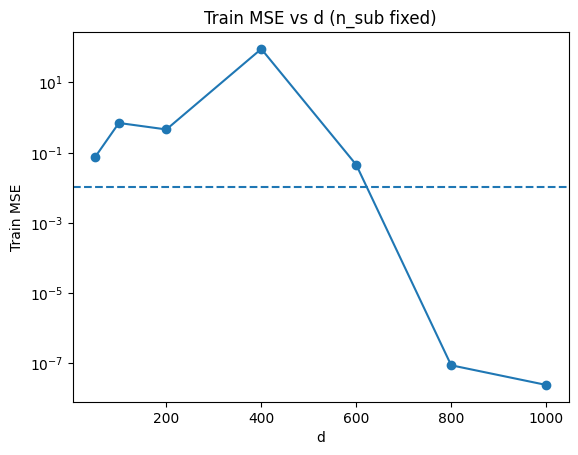

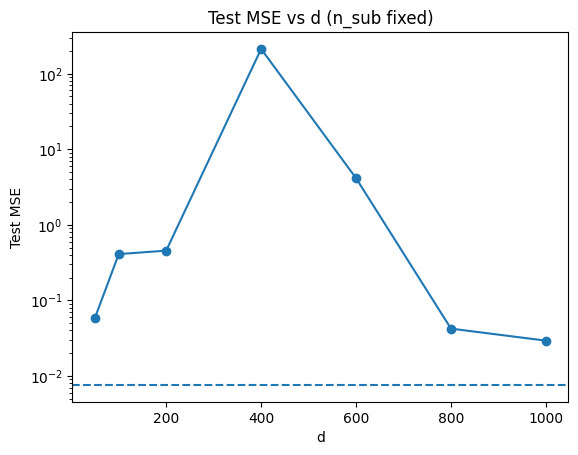

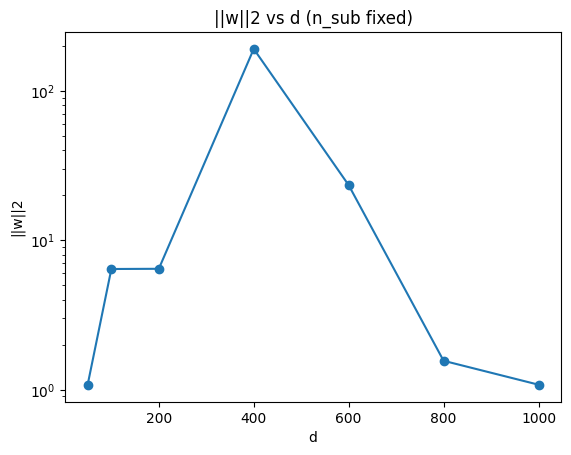

In [12]:
ds = np.array([r["d"] for r in rows])
tr = np.array([r["train_mse"] for r in rows])
te = np.array([r["test_mse"] for r in rows])
nm = np.array([r["norm"] for r in rows])

plt.figure()
plt.plot(ds, tr, marker="o")
plt.axhline(base_train, linestyle="--")
plt.yscale("log")
plt.title("Train MSE vs d (n_sub fixed)")
plt.xlabel("d"); plt.ylabel("Train MSE")
plt.show()

plt.figure()
plt.plot(ds, te, marker="o")
plt.axhline(base_test, linestyle="--")
plt.yscale("log")
plt.title("Test MSE vs d (n_sub fixed)")
plt.xlabel("d"); plt.ylabel("Test MSE")
plt.show()

plt.figure()
plt.plot(ds, nm, marker="o")
plt.yscale("log")
plt.title("||w||2 vs d (n_sub fixed)")
plt.xlabel("d"); plt.ylabel("||w||2")
plt.show()


In [13]:
# Build ONE dataset instance (same as inside fit function) so we can manipulate w
rng = np.random.default_rng(0)
idx = rng.choice(X_train_base.shape[0], size=n_sub, replace=False)
Xb_tr = X_train_base[idx]; y_tr = y_train[idx]

tidx = rng.choice(X_test_base.shape[0], size=2000, replace=False)
Xb_te = X_test_base[tidx]; y_te = y_test[tidx]

d0 = Xb_tr.shape[1]
d = 1000
m = d - d0
W = rng.normal(size=(d0, m)).astype(np.float32)
b = rng.normal(size=(m,)).astype(np.float32)

Z_tr = np.maximum(0, Xb_tr @ W + b)
Z_te = np.maximum(0, Xb_te @ W + b)
X_tr = np.hstack([Xb_tr, Z_tr]).astype(np.float32)
X_te = np.hstack([Xb_te, Z_te]).astype(np.float32)

# Interpolating-ish solution
lam = 1e-4
K = X_tr @ X_tr.T
alpha = np.linalg.solve(K + lam*np.eye(n_sub, dtype=np.float32), y_tr)
w = X_tr.T @ alpha

train_mse_w = float(np.mean((X_tr @ w - y_tr)**2))
test_mse_w  = float(np.mean((X_te @ w - y_te)**2))
print("good-ish interp:", train_mse_w, test_mse_w, np.linalg.norm(w))

# Find a null-space direction v: X_tr @ v ≈ 0
U, S, Vt = np.linalg.svd(X_tr, full_matrices=True)
# Vt is (d, d). Nullspace basis are rows corresponding to near-zero singular values: indices >= rank
rank = np.sum(S > 1e-6)
v = Vt[rank]          # one null direction (shape (d,))
v = v / (np.linalg.norm(v) + 1e-12)

# Make a high-norm interpolator
A = 100.0
w_bad = w + A * v

train_mse_bad = float(np.mean((X_tr @ w_bad - y_tr)**2))
test_mse_bad  = float(np.mean((X_te @ w_bad - y_te)**2))

print("BAD interp (same train, worse test):")
print("train_mse:", train_mse_bad)
print("test_mse :", test_mse_bad)
print("||w||2   :", float(np.linalg.norm(w_bad)))


good-ish interp: 2.4054277170306655e-08 0.02932983885133175 1.0793038356957685
BAD interp (same train, worse test):
train_mse: 2.4188380020609943e-08
test_mse : 112.46179760108879
||w||2   : 100.00582445630353


We construct two interpolating solutions with identical training error. One solution, selected by a minimum-norm criterion, generalizes moderately well, while another, obtained by perturbing in the null space, exhibits catastrophic test error despite perfect interpolation. This demonstrates that interpolation alone does not determine generalization performance; rather, the geometry and norm of the interpolating solution are crucial. This behavior is consistent with the theory of benign overfitting.

50 0.07507229091992894 0.058988952770231466 1.0756861780951075
100 0.6981572450778694 0.40985123296592285 6.416991526566163
200 0.4561976982822593 0.4555693832209381 6.437446254737341
400 89.82832402157938 212.59644071277918 190.49293064205722
600 0.04498554850911754 4.138303133916817 23.35309874711385
800 8.734067839764769e-08 0.04229568282771284 1.5601270643104121
1000 2.4054277170306655e-08 0.02932983885133175 1.0793038356957685
1200 8.211733256970854e-09 0.023300962323984157 0.8880047902868264


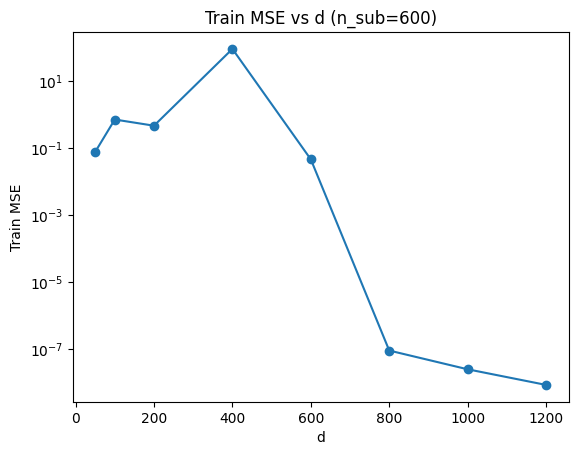

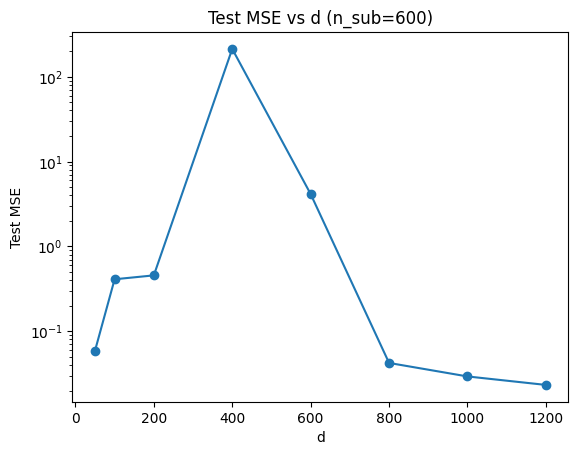

In [14]:
n_sub = 600
d_list = [50, 100, 200, 400, 600, 800, 1000, 1200]
lam = 1e-4
seed = 0

rows = []
for d in d_list:
    tr, te, nm = fit_relu_random_features_kernel(
        X_train_base, y_train, X_test_base, y_test,
        n_sub=n_sub, t_sub=2000, d=d, lam=lam, seed=seed
    )
    rows.append((d, tr, te, nm))
    print(d, tr, te, nm)

ds  = np.array([r[0] for r in rows])
trm = np.array([r[1] for r in rows])
tem = np.array([r[2] for r in rows])

plt.figure()
plt.plot(ds, trm, marker="o")
plt.yscale("log")
plt.title("Train MSE vs d (n_sub=600)")
plt.xlabel("d"); plt.ylabel("Train MSE")
plt.show()

plt.figure()
plt.plot(ds, tem, marker="o")
plt.yscale("log")
plt.title("Test MSE vs d (n_sub=600)")
plt.xlabel("d"); plt.ylabel("Test MSE")
plt.show()


Why benign overfitting is especially relevant in finance

Finance has three properties that make benign overfitting nontrivial:

(A) Low signal-to-noise
Forward returns are extremely noisy.
- Most features have weak predictive power
- Classical wisdom: “Overfitting is inevitable”

Your experiments already challenge this:
- You showed interpolation is possible
- You showed some interpolators generalize better than others

This directly connects to modern debates like:
- “Why do large models trained on noisy financial data not completely fail out of sample?”

(B) Many correlated predictors, few true degrees of freedom

In finance:
- Thousands of signals
- Strong correlations
- Effective dimension is much smaller than raw feature count

This mirrors the benign overfitting theory assumptions:
- High-dimensional
- Strong correlations
- Structured feature geometry

Your rank vs parameter-count discovery is exactly this phenomenon.